This notebook is an example notebook for processing VAMPIRES polarimetric imaging frames using the pyMuellerMat package to create a system Mueller matrix

In [2]:
from pyMuellerMat import common_mms as cmm
from pyMuellerMat import MuellerMat
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

#Some nicer printing options to avoid machine errors
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

## Let's build up a perfect Mueller Matrix

Now all the individual Mueller matrix components. For now we assume that we can remove the instrumental polarization in the data afterwards and that all the other components are ideal

In [3]:
wollaston_mm = cmm.WollastonPrism()
hwp_mm = cmm.Retarder() 
hwp_mm.properties['phi'] = 2*np.pi*0.5 #Make the HWP an ideal HWP
image_rotator = cmm.Retarder(name ="image_rotator")
image_rotator.properties['phi'] = 2*np.pi*0.48 #Changing this value changes the retardance of the derotator
sky_mm = cmm.Rotator(name="sky_pa")
ip_mm = cmm.InstrumentalPolarization(name="ip")
ip_mm.properties['IPQ'] = 0.02
ip_mm.properties['IPU'] = 0.02
altitude_mm = cmm.Rotator(name="altitude")

Combine all the individual components into a system 

In [4]:
sys_mm = MuellerMat.SystemMuellerMatrix([wollaston_mm,image_rotator,hwp_mm])
# sys_mm = MuellerMat.SystemMuellerMatrix([wollaston_mm,fast_hwp_mm,hwp_mm,altitude_mm,sky_mm]) #No image rotator

In [5]:
input_system = MuellerMat.SystemMuellerMatrix([altitude_mm,ip_mm])
S0 = [1,0,0,0]

qs = []
us = []
S_ins = []
for i in range(90):
    input_system.master_property_dict['altitude']['pa'] = i
    S_in = np.matmul(input_system.evaluate(),S0)
    S_ins.append(S_in)
    qs.append(S_in[1])
    us.append(S_in[2])
S_ins = np.array(S_ins)


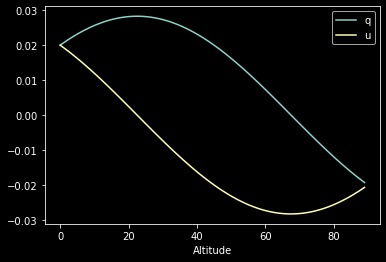

In [6]:
#What are teh 
plt.plot(S_ins[:,1],label="q")
plt.plot(S_ins[:,2],label="u")

plt.xlabel("Altitude")
plt.legend()

In [7]:
#An Array to hold the I for each camera
flcs = np.zeros([2,4,90])

#The HWP Angles
hwps = [0.,45,22.5,67.5]

#The image rotator angles - completely made up for now
imrot_angle = np.linspace(45,60,90)

#Generate the measurements
for i in range(90):
    for j in range(4):
        sys_mm.master_property_dict['Retarder']['theta'] = hwps[j]
        sys_mm.master_property_dict['image_rotator']['theta'] = imrot_angle[i]
    
        sys_mm.master_property_dict['WollastonPrism']['beam'] = 'o'
        flcs[0,j,i] = np.matmul(sys_mm.evaluate()[0],S_ins[i])
        sys_mm.master_property_dict['WollastonPrism']['beam'] = 'e'
        flcs[1,j,i] = np.matmul(sys_mm.evaluate()[0],S_ins[i])

In [8]:
#Do the double difference. 
diff = flcs[0]-flcs[1]
double_diffQ = (diff[0]-diff[1])/2
double_diffU = (diff[2]-diff[3])/2

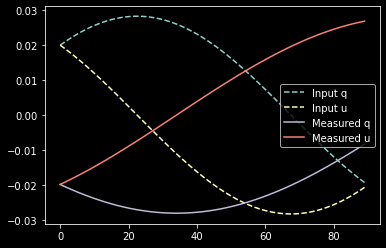

In [11]:
plt.plot(S_ins[:,1],linestyle='--',label="Input q")
plt.plot(S_ins[:,2],linestyle='--',label="Input u")

plt.plot(double_diffQ,label="Measured q")
plt.plot(double_diffU,label="Measured u")

plt.legend()